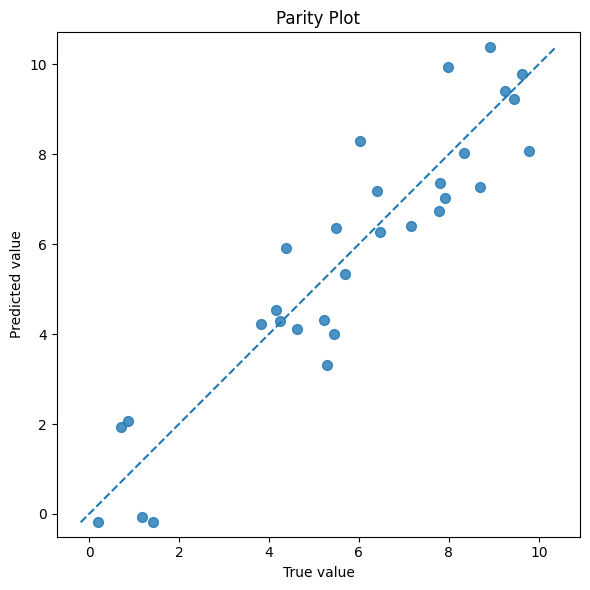

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Beispiel-Daten (random)
# -----------------------------
np.random.seed(0)
y_true = np.random.uniform(0, 10, 30)
y_pred = y_true + np.random.normal(scale=1.0, size=len(y_true))

# -----------------------------
# Parity Plot
# -----------------------------
plt.figure(figsize=(6, 6))

plt.scatter(y_true, y_pred, s=50, alpha=0.8)

# Winkelhalbierende y = x
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle="--",
    linewidth=1.5
)

plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.title("Parity Plot")
plt.axis("equal")
plt.tight_layout()

# -----------------------------
# Speichern
# -----------------------------
save = True

if save:
    plt.savefig("parity_plot_example.png", dpi=300, bbox_inches="tight")

plt.show()


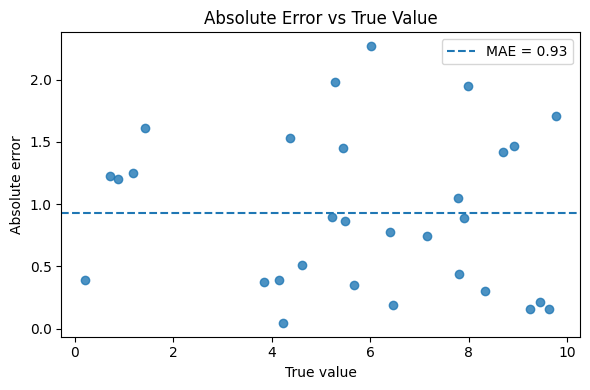

In [3]:
error = np.abs(y_true - y_pred)

plt.figure(figsize=(6, 4))
plt.scatter(y_true, error, alpha=0.8)
plt.axhline(error.mean(), linestyle="--", label=f"MAE = {error.mean():.2f}")

plt.xlabel("True value")
plt.ylabel("Absolute error")
plt.title("Absolute Error vs True Value")
plt.legend()
plt.tight_layout()
save1 = True

if save1:
    plt.savefig("MAE_plot_example.png", dpi=300, bbox_inches="tight")


plt.show()


Figure saved as: kfold_cv_10fold.png


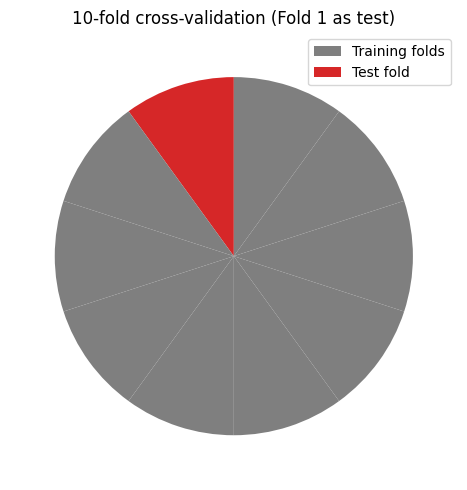

In [4]:
import matplotlib.pyplot as plt

def plot_kfold_pie(k=10, test_fold_index=0, save=False, filename="kfold_pie.png"):
    # Alle Folds gleich groß
    sizes = [1] * k
    
    # Farben: Training hell, Test dunkel
    colors = []
    for i in range(k):
        if i == test_fold_index:
            colors.append("tab:red")      # Test-Fold
        else:
            colors.append("tab:gray")     # Trainings-Folds

    # Labels nur für Legende wichtig, im Pie selbst blenden wir sie aus
    labels = [f"Fold {i+1}" for i in range(k)]

    fig, ax = plt.subplots(figsize=(5, 5))
    wedges, _ = ax.pie(
        sizes,
        labels=None,    # keine Beschriftung direkt im Kreis
        colors=colors,
        startangle=90
    )

    # Legende: Training vs. Test
    from matplotlib.patches import Patch
    legend_handles = [
        Patch(facecolor="tab:gray", label="Training folds"),
        Patch(facecolor="tab:red", label="Test fold"),
    ]
    ax.legend(handles=legend_handles, loc="upper right")

    ax.set_title(f"{k}-fold cross-validation (Fold {test_fold_index+1} as test)")

    plt.tight_layout()

    if save:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Figure saved as: {filename}")

    plt.show()

# Beispiel-Aufruf:
plot_kfold_pie(k=10, test_fold_index=0, save=True, filename="kfold_cv_10fold.png")


In [ ]:
temp = 298
p1, p2, p3 = [0.1, 1, 5]

states = np.array([1, 2, 3])
labels = ["State 1", "State 2", "State 3"]

data_r2_kg=[0.9119, 0.5912, 0.4378] # 20 Bins
data_mae_kg=[0.0347, 0.2824, 0.462]
data_mape_kg=[7.93, 15.45, 13.95]
data_r2_N=[0.9344, 0.6326, 0.3959]
data_mae_N=[12.33, 11.36, 3.8133]
data_mape_N=[6.67, 13.92, 13.75]


data_r2_Nscaled=[0.9344, 0.6326, 0.3959]
data_mae_Nscaled=[12.33, 11.36, 3.8133]
data_mape_Nscaled=[6.67, 13.92, 13.75]
data_r2_Nscaled=[0.9344, 0.6326, 0.3959]
data_mae_Nscaled=[12.33, 11.36, 3.8133]
data_mape_Nscaled=[6.67, 13.92, 13.75]

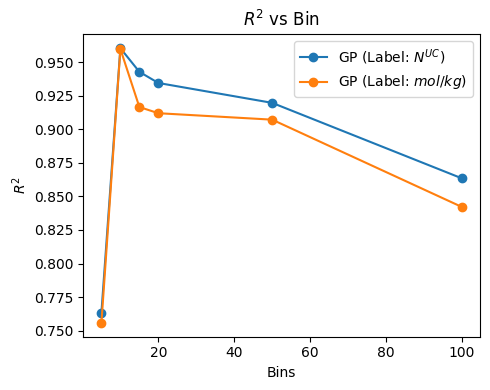

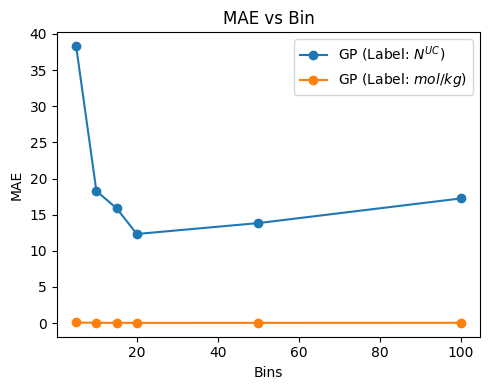

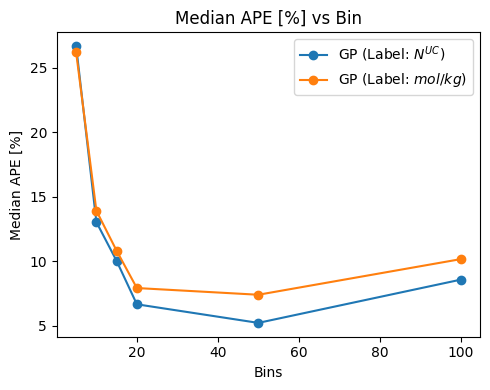

In [33]:
import pandas as pd
import os
data=pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Sicherung1.csv", sep=";")

save_dir = "/Users/danielbock/MASTERTHESIS/MASTA/TestBench/"
os.makedirs(save_dir, exist_ok=True)

label_map = {
    "mol/kg": r"GP (Label: $mol/kg$)",
    "N": r"GP (Label: $N^{UC}$)"
}

def plot_metric_by_bin(data, metric, ylabel, filename):
    plt.figure(figsize=(5, 4))

    for label_name, df_label in data.groupby("Label"):
        df_label = df_label.sort_values("Bins")
        plt.p lot(
            df_label["Bins"],
            df_label[metric],
            marker="o",
            label=label_map.get(label_name, label_name)
        )

    plt.xlabel("Bins")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel}")
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

plot_metric_by_bin(
    data,
    metric="R2",
    ylabel=r"$R^2$",
    filename="R2_vs_Bin.png"
)

plot_metric_by_bin(
    data,
    metric="MAE",
    ylabel="MAE",
    filename="MAE_vs_Bin.png"
)

plot_metric_by_bin(
    data,
    metric="MAPE",   # oder "Median_APE_percent"
    ylabel="MAPE",
    filename="Median_APE_vs_Bin.png"
)


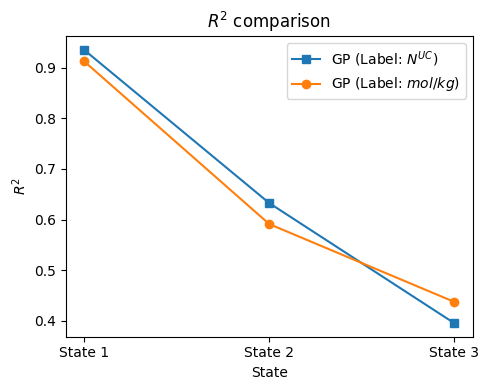

In [35]:
plt.figure(figsize=(5, 4))

plt.plot(states, data_r2_N,  marker="s", label="GP (Label: $N^{UC}$)")
plt.plot(states, data_r2_kg, marker="o", label="GP (Label: $mol/kg$)")

plt.xticks(states, labels)
plt.xlabel("State")
plt.ylabel(r"$R^2$")
plt.title(r"$R^2$ comparison")
plt.legend()
plt.tight_layout()
save3 = True

if save3:
    plt.savefig("R2plot.png", dpi=300, bbox_inches="tight")

plt.show()


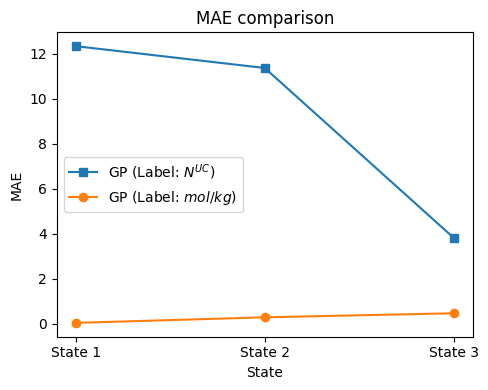

In [36]:
plt.figure(figsize=(5, 4))

plt.plot(states, data_mae_N,  marker="s", label="GP (Label: $N^{UC}$)")
plt.plot(states, data_mae_kg, marker="o", label="GP (Label: $mol/kg$)")

plt.xticks(states, labels)
plt.xlabel("State")
plt.ylabel("MAE")
plt.title("MAE comparison")
plt.legend()
plt.tight_layout()
save4 = True

if save4:
    plt.savefig("MAEplot.png", dpi=300, bbox_inches="tight")
plt.show()


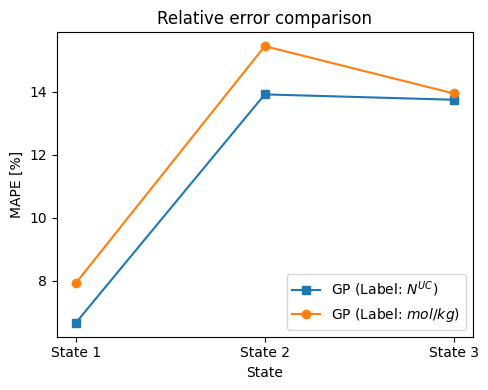

In [37]:
plt.figure(figsize=(5, 4))

plt.plot(states, data_mape_N,  marker="s", label="GP (Label: $N^{UC}$)")
plt.plot(states, data_mape_kg, marker="o", label="GP (Label: $mol/kg$)")

plt.xticks(states, labels)
plt.xlabel("State")
plt.ylabel("MAPE [%]")
plt.title("Median APE vs state")
plt.legend()
plt.tight_layout()
save5 = True

if save5:
    plt.savefig("MAPEplot.png", dpi=300, bbox_inches="tight")
plt.show()


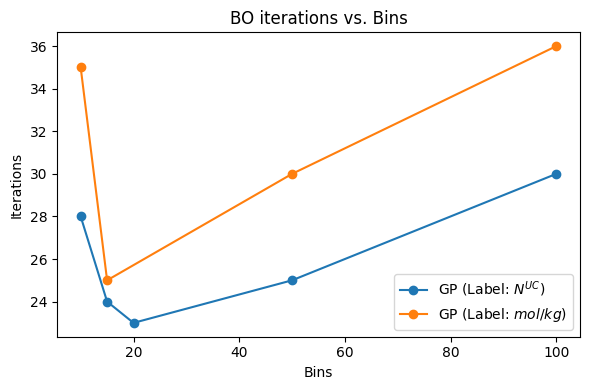

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Daten laden
df = pd.read_csv(
    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Sicherung1.csv",
    sep=";"
)

# Optional (empfohlen): nur erfolgreiche BO-Runs
df = df[df["found_best"] == True]

# Label-Mapping
label_map = {
    "mol/kg": r"GP (Label: $mol/kg$)",
    "N": r"GP (Label: $N^{UC}$)"
}

plt.figure(figsize=(6, 4))

for label, df_label in df.groupby("Label"):
    grouped = (
        df_label
        .groupby("Bins")["Iterations"]
        .mean()          # oder .median()
        .sort_index()
    )

    plt.plot(
        grouped.index,
        grouped.values,
        marker="o",
        label=label_map.get(label, label)  # ✅ Mapping hier
    )

plt.xlabel("Bins")
plt.ylabel("Iterations")
plt.title("BO iterations vs. Bins")
plt.legend()
plt.tight_layout()
save8 = True

if save8:
    plt.savefig("BOplot.png", dpi=300, bbox_inches="tight")
plt.show()





In [ ]:
import pandas as pd 
data = pd.read_csv('/Users/danielbock/MASTERTHESIS/MASTA/TestBench/logs/gp_summary_data_swing_Vext_densB.csv')
#data = data[data["found_global_best"]==True]
data = data[data["temperature_kelvin_1"]==298]
data = data[data["temperature_kelvin_2"]==298]
data = data[data["pressure_bar_1"]==1]
data = data[data["pressure_bar_2"]==0.001]

In [ ]:
data

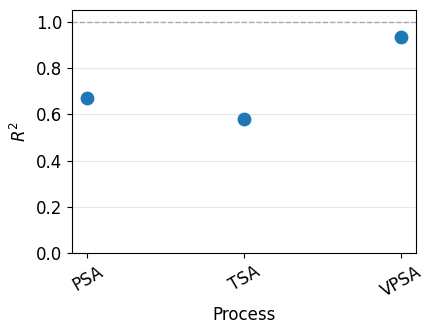

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(
    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Sicherung2.csv",
    sep=";"
)
plt.figure(figsize=(4.5, 3.5))
plt.scatter(data["Name"], data["r2_score"], s=80, zorder=3)

plt.axhline(1.0, color="gray", linestyle="--", linewidth=1, alpha=0.6)

plt.ylabel(r"$R^2$")
plt.xlabel("Process")
plt.xticks(rotation=30)
plt.ylim(0, 1.05)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



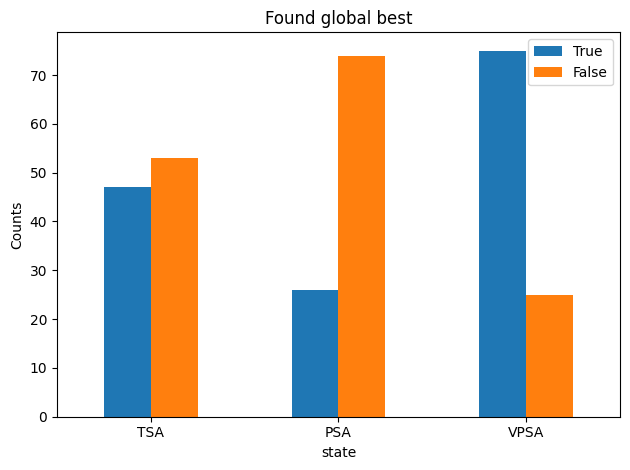

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(
    '/Users/danielbock/MASTERTHESIS/MASTA/TestBench/logs/bo_runs_data_swing_Test_Präsentation.csv'
)

# Zustände definieren
states = {
    "TSA": dict(T1=400, T2=298, p1=1, p2=1),
    "PSA": dict(T1=298, T2=298, p1=5, p2=1),
    "VPSA": dict(T1=298, T2=298, p1=1, p2=0.001),
}

results = []

for name, s in states.items():
    subset = data[
        (data["temperature_kelvin_T1"] == s["T1"]) &
        (data["temperature_kelvin_T2"] == s["T2"]) &
        (data["pressure_bar_1"] == s["p1"]) &
        (data["pressure_bar_2"] == s["p2"])
    ]

    counts = subset["found_global_best"].value_counts()
    results.append({
        "state": name,
        "True": counts.get(True, 0),
        "False": counts.get(False, 0),
    })

df_plot = pd.DataFrame(results).set_index("state")
df_plot.plot(kind="bar")

plt.ylabel("Counts")
plt.title("Found global best")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("BO_found_TSA_PSA_VPSA.png", dpi=300, bbox_inches="tight")
plt.show()


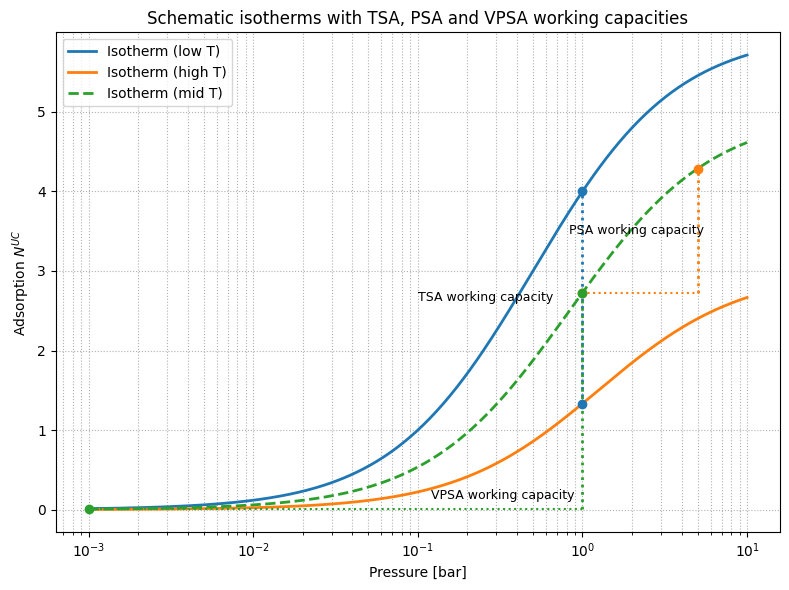

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Beispiel-Isothermen definieren
# -----------------------------
p = np.logspace(-3, 1, 300)  # Druck [bar], logarithmisch von 0.001 bis 10

def langmuir(p, qmax, b):
    """Einfache Langmuir-Isotherme als Demo."""
    return qmax * b * p / (1.0 + b * p)

# "Kalte" Isotherme (viel Adsorption)
q_T_low  = langmuir(p, qmax=6.0, b=2.0)

# "Warme" Isotherme (weniger Adsorption)
q_T_high = langmuir(p, qmax=3.0, b=0.8)

# Isotherme für PSA/VPSA (z.B. mittlere Temperatur)
q_T_mid = langmuir(p, qmax=5.0, b=1.2)

# -----------------------------
# 2) Working capacities definieren
# -----------------------------
# TSA: Working capacity bei festem Druck p_TSA aus T_low -> T_high
p_TSA = 1.0
q_TSA_lowT  = np.interp(p_TSA, p, q_T_low)
q_TSA_highT = np.interp(p_TSA, p, q_T_high)

# PSA: Working capacity zwischen p_low und p_high auf derselben Isotherme (q_T_mid)
p_PSA_low  = 1
p_PSA_high = 5.0
q_PSA_low  = np.interp(p_PSA_low,  p, q_T_mid)
q_PSA_high = np.interp(p_PSA_high, p, q_T_mid)

# VPSA: Working capacity zwischen "fast Vakuum" und hohem Druck
p_VPSA_low  = 0.001
p_VPSA_high = 1.0
q_VPSA_low  = np.interp(p_VPSA_low,  p, q_T_mid)
q_VPSA_high = np.interp(p_VPSA_high, p, q_T_mid)

# -----------------------------
# 3) Plot
# -----------------------------
plt.figure(figsize=(8, 6))

# Isothermen
plt.plot(p, q_T_low,  label="Isotherm (low T)",  lw=2)
plt.plot(p, q_T_high, label="Isotherm (high T)", lw=2)
plt.plot(p, q_T_mid,  label="Isotherm (mid T)",  lw=2, ls="--")

# --- TSA: vertikale Differenz bei p_TSA ---
plt.scatter([p_TSA, p_TSA], [q_TSA_lowT, q_TSA_highT], color="C0", zorder=3)
plt.vlines(p_TSA, q_TSA_highT, q_TSA_lowT, colors="C0", linestyles=":", lw=2)
plt.text(
    p_TSA * 0.1,
    (q_TSA_lowT + q_TSA_highT) / 2,
    "TSA working capacity",
    va="center",
    fontsize=9,
)

# --- PSA: Differenz entlang der Isotherme q_T_mid (p_low -> p_high) ---
plt.scatter([p_PSA_low, p_PSA_high], [q_PSA_low, q_PSA_high], color="C1", zorder=3)
plt.hlines(q_PSA_low,  p_PSA_low, p_PSA_high, colors="C1", linestyles=":")
plt.vlines(p_PSA_high, q_PSA_low, q_PSA_high, colors="C1", linestyles=":", lw=2)
plt.text(
    p_PSA_high * 1.1,
    (q_PSA_low + q_PSA_high) / 2,
    "PSA working capacity",
    ha="right",
    va="center",
    fontsize=9,
)

# --- VPSA: Differenz zwischen sehr niedrigem und hohem Druck ---
plt.scatter([p_VPSA_low, p_VPSA_high], [q_VPSA_low, q_VPSA_high], color="C2", zorder=3)
plt.hlines(q_VPSA_low,  p_VPSA_low, p_VPSA_high, colors="C2", linestyles=":")
plt.vlines(p_VPSA_high, q_VPSA_low, q_VPSA_high, colors="C2", linestyles=":", lw=2)
plt.text(
    p_VPSA_high * 0.9,
    (q_VPSA_low + q_VPSA_high) / 15,
    "VPSA working capacity",
    ha="right",
    va="center",
    fontsize=9,
)

# Achsen + Layout
plt.xscale("log")
plt.xlabel("Pressure [bar]")
plt.ylabel("Adsorption $N^{UC}$")
plt.title("Schematic isotherms with TSA, PSA and VPSA working capacities")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()

# Optional: speichern
plt.savefig("isotherms_TSA_PSA_VPSA.png", dpi=300, bbox_inches="tight")

plt.show()


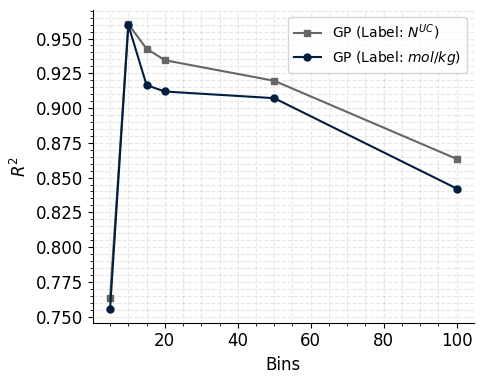

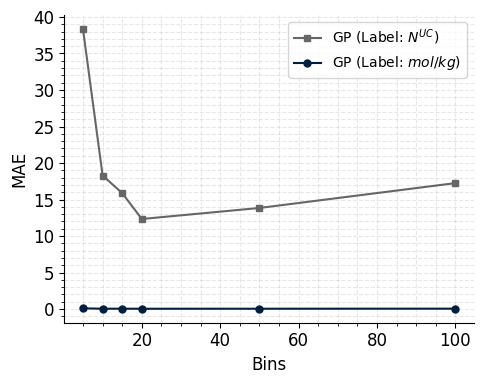

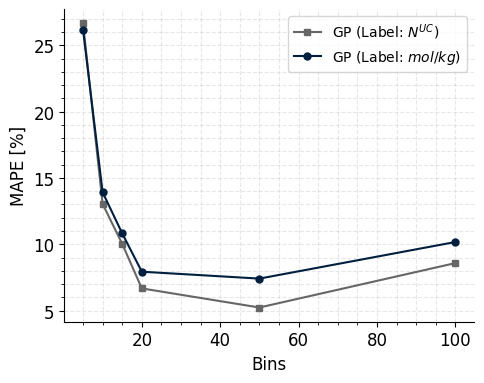

In [97]:
import pandas as pd
import os
import matplotlib.pyplot as plt

data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Sicherung1.csv", sep=";")

save_dir = "/Users/danielbock/MASTERTHESIS/MASTA/TestBench/"
os.makedirs(save_dir, exist_ok=True)

# Einheitlicher Schriftstil
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 10
})

label_map = {
    "mol/kg": r"GP (Label: $mol/kg$)",
    "N": r"GP (Label: $N^{UC}$)"
}

# Farben & Marker für die zwei Labels
color_map = {
    "mol/kg": "#001f3f",  # Navy
    "N": "#666666"        # Grau
}

marker_map = {
    "mol/kg": "o",
    "N": "s"
}

def plot_metric_by_bin(data, metric, ylabel, filename):
    fig, ax = plt.subplots(figsize=(5, 4))

    for label_name, df_label in data.groupby("Label"):
        df_label = df_label.sort_values("Bins")

        ax.plot(
            df_label["Bins"],
            df_label[metric],
            marker=marker_map.get(label_name, "o"),
            linestyle="-",
            linewidth=1.5,
            markersize=5,
            color=color_map.get(label_name, "#333333"),
            label=label_map.get(label_name, label_name)
        )

    ax.set_xlabel("Bins")
    ax.set_ylabel(ylabel)
    # Titel optional – in einer Arbeit kann man hier auch einfach den Abbildungstitel im Text verwenden
    # ax.set_title(ylabel)

    # Dezentes Grid
    ax.grid(True, which="both", linestyle="--", alpha=0.3)

    # Minor-Ticks
    ax.minorticks_on()

    # Cleanere Ränder
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend()
    fig.tight_layout()

    save_path_png = os.path.join(save_dir, filename)
    fig.savefig(save_path_png, dpi=300, bbox_inches="tight")
    
    # Optional: zusätzlich als PDF
    save_path_pdf = save_path_png.replace(".png", ".pdf")
    fig.savefig(save_path_pdf, bbox_inches="tight")

    plt.show()

plot_metric_by_bin(
    data,
    metric="R2",
    ylabel=r"$R^2$",
    filename="R2_vs_Bin.png"
)

plot_metric_by_bin(
    data,
    metric="MAE",
    ylabel="MAE",  # ggf. Einheit anpassen
    filename="MAE_vs_Bin.png"
)

plot_metric_by_bin(
    data,
    metric="MAPE",   # oder "Median_APE_percent"
    ylabel="MAPE [%]",
    filename="MAPE_vs_Bin.png"
)
